**Implementing Type 2 Slowly Changing Dimensions (SCD)**

**Slowly Changing Dimension (SCD)**

SCD refers to how changes in dimension data (e.g., employee name, address, department) are handled over time in a data warehouse or lakehouse.

It ensures that updates to dimensional values are tracked accurately — either by overwriting, preserving history, or both.

 **<u>Types of SCD</u>**

1. **SCD Type 0 – Fixed**
- No changes allowed.
- Original data remains unchanged.

2. **SCD Type 1 – Overwrite**
- Updates the record in place.
- No history is preserved.

3. **SCD Type 2 – Add New Row (Full History)**
- A new row is added for each change.
- Includes metadata: StartDate, EndDate, IsCurrent.
- Preserves full history.

4. **SCD Type 3 – Add New Column**
- Adds a column to store previous value(s).
- Tracks only limited history (e.g., last value).

5. **SCD Type 4 – History Table**
- Keeps current data in the main table.
- Stores history in a separate table.

6. **SCD Type 6 – Hybrid**
- Combines Types 1, 2, and 3.
- Tracks full and partial history with added flexibility.


**_**Note:  **_**
_**This notebook implements SCD Type 2 using PySpark — storing historical changes as new rows in a Delta Table.**_


StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 6, Finished, Available, Finished)

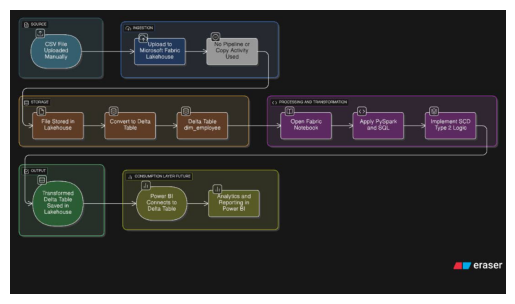

In [4]:
#Architectural Design

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Load image
image = mpimg.imread(f"{notebookutils.nbResPath}/builtin/fabric project image.jpg")
# Let the axes disappear
plt.axis('off')
# Plot image in the output
image_plot = plt.imshow(image)


In [5]:
#Load the data 
df = spark.sql("SELECT * FROM Employee_Lakehouse.dbo.`employee data` LIMIT 1000")
display(df)

StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 7, Finished, Available, Finished)

DataFrame[EmpID: int, Name: string, Gender: string, JobTitle: string, Department: string, LoadDate: string]

In [6]:
# Convert the LoadDate column from string to Date

from pyspark.sql.functions import trim, when, to_date,col

employee_data = df.withColumn(
    "LoadDate",
    to_date(
        when(trim(col("LoadDate")).isin("", "NaT", "null"), None)
        .otherwise(col("LoadDate"))
    )
)


StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 8, Finished, Available, Finished)

In [7]:
display(employee_data)

StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 9, Finished, Available, Finished)

DataFrame[EmpID: int, Name: string, Gender: string, JobTitle: string, Department: string, LoadDate: date]

In [8]:

from pyspark.sql.functions import col, to_date, current_date, coalesce

# Fill in the rows with Null values with the current date
employee_data = employee_data.withColumn(
    "LoadDate",
    to_date(coalesce(col("LoadDate"), current_date()))
)

display(employee_data)

StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 10, Finished, Available, Finished)

DataFrame[EmpID: int, Name: string, Gender: string, JobTitle: string, Department: string, LoadDate: date]

In [9]:
#Drop duplicate rows
cleaned_employee_data= employee_data.dropDuplicates()
display(cleaned_employee_data)

StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 11, Finished, Available, Finished)

DataFrame[EmpID: int, Name: string, Gender: string, JobTitle: string, Department: string, LoadDate: date]

In [10]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType
from pyspark.sql import SparkSession


# Create a dim_employee table and define schema for SCD Type 2 dimension table
dim_schema = StructType([
    StructField("EmpID", IntegerType(), False),        
    StructField("Name", StringType(), True),         
    StructField("Gender", StringType(), True),
    StructField("JobTitle", StringType(), True),       
    StructField("Department", StringType(), True),     
    StructField("StartDate", DateType(), True),    
    StructField("EndDate", DateType(), True),          
    StructField("IsActive", StringType(), True)        
])

# Create an empty DataFrame using this schema
empty_dim_df = spark.createDataFrame([], schema=dim_schema)

# Save as a table in your Fabric Lakehouse
empty_dim_df.write.mode("overwrite").saveAsTable("dim_employee")


StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 12, Finished, Available, Finished)

In [11]:
spark.read.table("dim_employee").show()


StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 13, Finished, Available, Finished)

+-----+----+------+--------+----------+--------+---------+-------+--------+
|EmpID|Name|Gender|JobTitle|Department|LoadDate|StartDate|EndDate|IsActive|
+-----+----+------+--------+----------+--------+---------+-------+--------+
+-----+----+------+--------+----------+--------+---------+-------+--------+



In [12]:
from pyspark.sql.window import Window

# Partitioned by EmpID and LoadDate to compare row values and identify changes
emp_window = Window.partitionBy("EmpID").orderBy("LoadDate")



StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 14, Finished, Available, Finished)

In [16]:
from pyspark.sql.functions import lead,date_sub,lit
# Created a new column startdate which will contain the same value as LoadDate
# Used lead() to get the next LoadDate for EndDate 
# Used Lit() to set EndDate  and IsActive logic

dim_employee_final =(cleaned_employee_data 
    .withColumn("StartDate", col("LoadDate")) 
    .withColumn("NextLoadDate", lead("LoadDate").over(emp_window)) 
    .withColumn("EndDate", 
                when(col("NextLoadDate").isNotNull(), date_sub(col("NextLoadDate"), 1))
                .otherwise(to_date(lit("0000-00-00")))) 
    .withColumn("IsActive", 
                when(col("NextLoadDate").isNull(), lit("Yes"))
                .otherwise(lit("No"))) 
    .drop("NextLoadDate"))

StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 18, Finished, Available, Finished)

In [17]:
dim_employee_final.show()


StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 19, Finished, Available, Finished)

+-----+---------------+------+---------------+----------+----------+----------+----------+--------+
|EmpID|           Name|Gender|       JobTitle|Department|  LoadDate| StartDate|   EndDate|IsActive|
+-----+---------------+------+---------------+----------+----------+----------+----------+--------+
|    1|   Allison Hill|  Male|   BI Developer|        IT|2023-06-01|2023-06-01|2025-07-21|      No|
|    1|   Allison Hill|  Male|   Data Analyst|        HR|2025-07-22|2025-07-22|      NULL|     Yes|
|    2|    Noah Rhodes|  Male|  Data Engineer|   Finance|2025-07-22|2025-07-22|      NULL|     Yes|
|    3|Angie Henderson|  Male|  Data Engineer|   Finance|2023-06-01|2023-06-01|2023-12-31|      No|
|    3|Angie Henderson|  Male|    ML Engineer|        IT|2024-01-01|2024-01-01|2025-07-21|      No|
|    3|Angie Henderson|  Male|Product Manager|        IT|2025-07-22|2025-07-22|      NULL|     Yes|
|    4|  Daniel Wagner|Female|   Data Analyst|        IT|2025-07-22|2025-07-22|      NULL|     Yes|


In [18]:
# Drop LoadDate before writing
dim_employee_final.drop("LoadDate")

#Write to dim_employee table
(dim_employee_final.write 
    .mode("overwrite") 
    .option("overwriteSchema", "true") 
    .saveAsTable("dim_employee"))

StatementMeta(, d13955fb-8d5f-4cc4-9aba-faf7126aa1cf, 20, Finished, Available, Finished)